## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col='datetime', parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df = df.resample('1H').sum()

In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

In [7]:
decomposed = seasonal_decompose(df)

In [8]:
df['num_orders_mean'] = df.rolling(10).mean()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


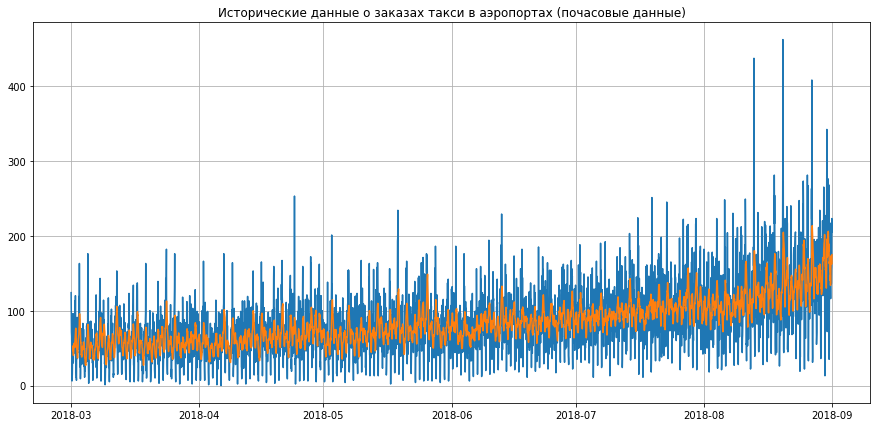

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Исторические данные о заказах такси в аэропортах (почасовые данные)')
plt.grid(True)
plt.show()

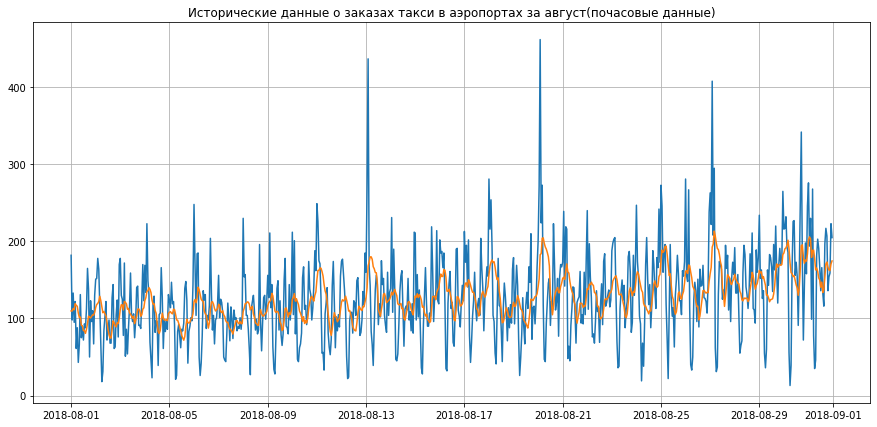

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(df['2018-08-01':'2018-08-31'])
plt.title('Исторические данные о заказах такси в аэропортах за август(почасовые данные)')
plt.grid(True)
plt.show()

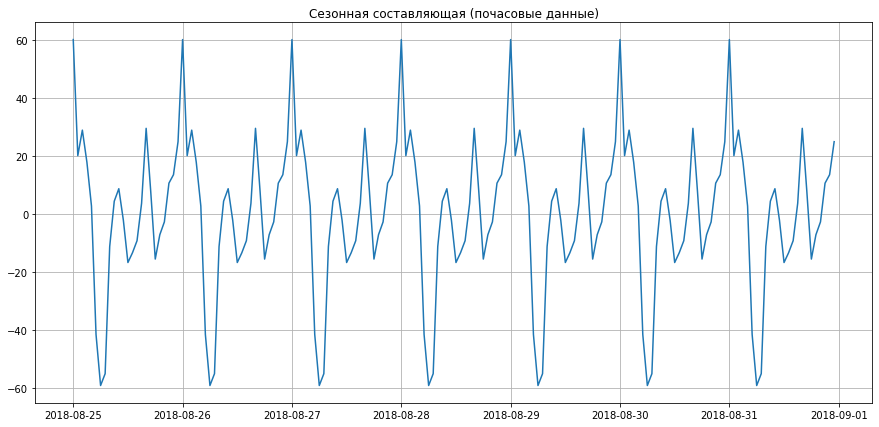

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.seasonal['2018-08-25':'2018-08-31'])
plt.title('Сезонная составляющая (почасовые данные)')
plt.grid(True)
plt.show()

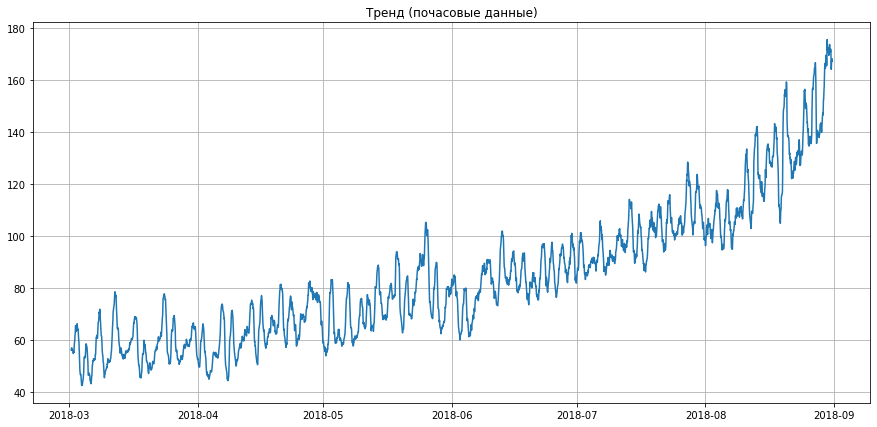

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.trend)
plt.title('Тренд (почасовые данные)')
plt.grid(True)
plt.show()

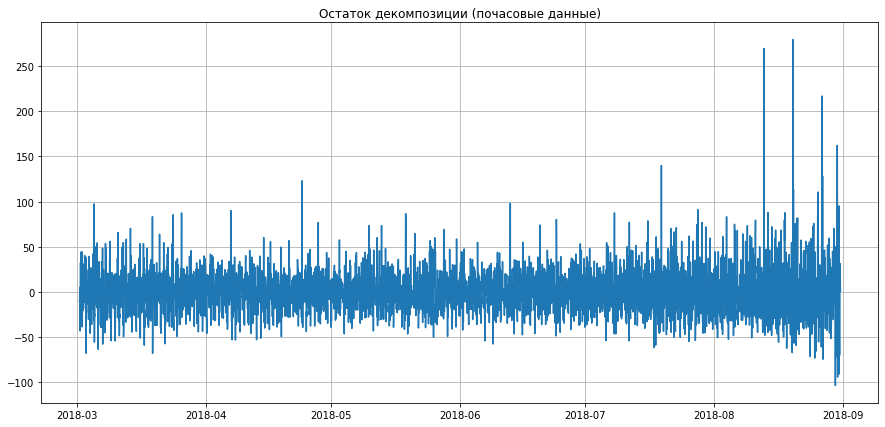

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(decomposed.resid)
plt.title('Остаток декомпозиции (почасовые данные)')
plt.grid(True)
plt.show()

Вывод:

Поздним вечером и ночью максимально много вызовов, это доказывает циклично повторяющиеся закономерность. Возможно, ночью плохо ходит общественный транспорт, вопрос безопасности и усталости клиента.

Тренд показывает количество заказов постоянно плавно растёт, ежемесячно увеличение объёма продаж авиабилетов.

# 3. Обучение

In [14]:
#Создание признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [15]:
df.shape

(4416, 2)

Вот тут нужна помощь. читал кучу статей и не понял. :(. Подскажи пожалуйста. Как мы подбираем max_lag, rolling_mean_size?

max_lag - максимальный размер отставания. Это на сколько шагов вперёд мы можем предсказать? а как его определить. У нас сейчас 4416 записей. мы выберем 10% для теста это 441 запись. Данный признак равен 440?


Lags of time series Shifting the series n steps back, we get a feature column where the current value of time series is aligned with its value at time t−n . If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.


в статье написано необходимо найти баланс между оптимальным качеством прогноза и длиной горизонта прогнозирования. А как его найти :)


rolling_mean_size Скользящее среднее. оно должно быть равно max_lag?


In [16]:
make_features(df,200,200)

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
#train, valid = train_test_split(train_v, shuffle=False, test_size=0.25)

In [18]:
train = train.dropna()

x_train = train.drop(['num_orders','num_orders_mean'],axis=1)
y_train = train['num_orders']

x_test = test.drop(['num_orders','num_orders_mean'],axis=1)
y_test = test['num_orders']

#x_valid = valid.drop(['num_orders','num_orders_mean'],axis=1)
#y_valid = valid['num_orders']

In [19]:
train.shape, test.shape

((3926, 55), (442, 55))

---

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
general_table = {}

---

LinearRegression

In [22]:
#Создаём распределение параметров
rs_params_LinearRegression = {'fit_intercept' : [True, False]}

In [23]:
model_LinearRegression = GridSearchCV(LinearRegression(),
                                      rs_params_LinearRegression,
                                      cv=tscv,
                                      scoring='neg_mean_squared_error').fit(x_train,y_train)

In [24]:
mean_squared_error(model_LinearRegression.predict(x_train), y_train)**0.5

23.347323316371693

In [25]:
np.sqrt(mean_squared_error(model_LinearRegression.predict(x_test), y_test))

43.15670563722799

In [26]:
general_table.update({"LinearRegression":np.sqrt(mean_squared_error(model_LinearRegression.predict(x_test), y_test))})

---

LGBMRegressor

In [27]:
from lightgbm import LGBMRegressor

In [28]:
model=LGBMRegressor()
model.fit(x_train,y_train)
predict = model.predict(x_train)

In [29]:
mean_squared_error(predict, y_train)**0.5

10.841794547386353

In [30]:
mean_squared_error(model.predict(x_test), y_test)**0.5

40.436231277971935

In [31]:
general_table.update({"LGBMRegressor":mean_squared_error(model.predict(x_test), y_test)**0.5})

---

CatBoostRegressor

In [32]:
from catboost import CatBoostRegressor

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Все импорты лучше располагать в начале тетрадки</div>

In [33]:
model=CatBoostRegressor(loss_function = 'MAE', eval_metric = 'RMSE')
model.fit(x_train,y_train)
predict = model.predict(x_train)

0:	learn: 38.3275794	total: 53.8ms	remaining: 53.7s
1:	learn: 37.7931104	total: 59.3ms	remaining: 29.6s
2:	learn: 37.3052347	total: 144ms	remaining: 47.8s
3:	learn: 36.8193004	total: 149ms	remaining: 37.2s
4:	learn: 36.3906063	total: 242ms	remaining: 48.2s
5:	learn: 35.9232462	total: 249ms	remaining: 41.2s
6:	learn: 35.5048514	total: 342ms	remaining: 48.6s
7:	learn: 35.1153595	total: 356ms	remaining: 44.2s
8:	learn: 34.6962033	total: 439ms	remaining: 48.4s
9:	learn: 34.3355977	total: 444ms	remaining: 44s
10:	learn: 33.9799838	total: 537ms	remaining: 48.3s
11:	learn: 33.6057330	total: 544ms	remaining: 44.8s
12:	learn: 33.2893246	total: 636ms	remaining: 48.3s
13:	learn: 32.9625573	total: 642ms	remaining: 45.2s
14:	learn: 32.6468181	total: 733ms	remaining: 48.1s
15:	learn: 32.3585994	total: 739ms	remaining: 45.4s
16:	learn: 32.0470332	total: 832ms	remaining: 48.1s
17:	learn: 31.7539854	total: 837ms	remaining: 45.7s
18:	learn: 31.4669724	total: 928ms	remaining: 47.9s
19:	learn: 31.2004029	

In [34]:
mean_squared_error(predict, y_train)**0.5

16.53599049528042

In [35]:
mean_squared_error(model.predict(x_test), y_test)**0.5

43.78086228363409

In [36]:
general_table.update({"CatBoostRegressor":mean_squared_error(model.predict(x_test), y_test)**0.5})

---

xgboost

In [37]:
from xgboost import XGBRegressor 

model=XGBRegressor()
model.fit(x_train,y_train)
predict = model.predict(x_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
mean_squared_error(predict, y_train)**0.5

19.2449093933999

In [39]:
mean_squared_error(model.predict(x_test), y_test)**0.5

41.13589046434784

In [40]:
general_table.update({"xgboost":mean_squared_error(model.predict(x_test), y_test)**0.5})

# 4. Тестирование

Спрогнозируем временные ряды без обучения, для оценки эффективности.

In [41]:
# 1 Способ
pred_median = np.ones(y_test.shape)*y_train.median()
print("RMSE:", mean_squared_error(y_test,pred_median)**0.5)

RMSE: 87.15277582981295


In [42]:
# 2 Способ
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("RMSE:", (mean_squared_error(pred_previous, y_test)**0.5))

RMSE: 58.856486242815066


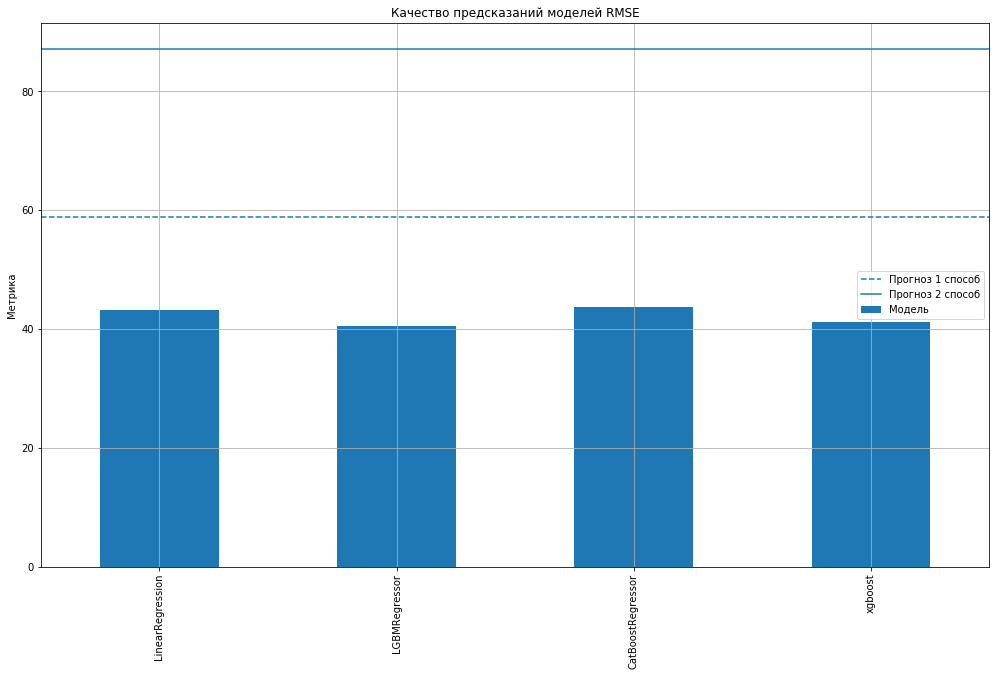

In [43]:
pd.Series(general_table).plot(grid=True,figsize=(17, 10),kind='bar',label = 'Модель')
plt.axhline(mean_squared_error(pred_previous, y_test)**0.5, xmin=0, xmax=1, linestyle = '--',label = 'Прогноз 1 способ')
plt.axhline(mean_squared_error(y_test,pred_median)**0.5, xmin=0, xmax=1, linestyle = '-',label = 'Прогноз 2 способ')
plt.title('Качество предсказаний моделей RMSE')
plt.ylabel('Метрика')
plt.legend()
plt.show()

Вывод:

Линейная регрессия дала нам наилучший прогноз.

# 5. Вывод

Анализ данных показал, что тренд указывает на увеличение заказов. Сезонность указывает на высокий спрос на такси в ночное время.


Мы посмотрели различные методы прогнозирования временных рядов. Линейная регрессия может достичь более или менее хороших результатов. RMSE на лучшей модели на тестовой выборке не превышает указанного в задании 48.
